<a href="https://colab.research.google.com/github/BrandonKTC/Pytorch_Deep_learning/blob/main/06_PyTorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.12.0+cu113
0.13.0+cu113


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/BrandonKTC/Pytorch_Deep_learning
    !mv Pytorch_Deep_learning/data . 
    !mv Pytorch_Deep_learning/going_modular .
    !rm -rf Pytorch_Deep_learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
fatal: destination path 'Pytorch_Deep_learning' already exists and is not an empty directory.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
!wget https://raw.githubusercontent.com/BrandonKTC/Pytorch_Deep_learning/main/helper_functions.py
from helper_functions import plot_loss_curves

## Get Data

In [4]:
import os, zipfile
from pathlib import Path

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data....")
  zip_ref.extractall(image_path)

Unzipping data....


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create Datasets and DataLoaders  

## 2.1 Creating a transform for torchvision.models (manual creation)


In [6]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[.485, .456, .406],
                                 std=[.229,.224,.225])
manual_transforms = transforms.Compose([
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        normalize
])

In [7]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,
                                                                               test_dir,
                                                                               manual_transforms,
                                                                               32)

## 2.2 Creating a transform for torchvision.models (auto creation)

In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,
                                                                               test_dir,
                                                                               auto_transforms,
                                                                               32)

## 3. Setting up a pretrained model

In [14]:
# OLD method creating a pretrained model
# model = torchvision.models.efficientnet_b0(pretrained=True)
# New method creating a pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Getting a summmary of our model

In [16]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [17]:
for param in model.features.parameters():
  param.requires_grad = False

In [23]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
)

In [24]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [25]:
# Define loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

In [27]:
# Import train function
from going_modular.going_modular import engine

# Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
# End the timer
end_time = timer()
print(f"[infp] Total training time: {end_time-start_time:.3f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
[infp] Total training time: 16.297 seconds.


## 5. Evaluate model by plotting the loss curve

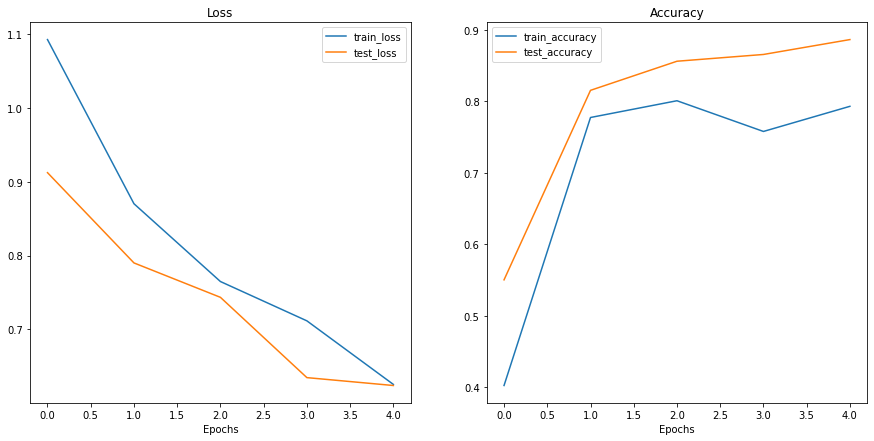

In [33]:
plot_loss_curves(results)

In [39]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model...
def pred_and_plot(model, image_path, class_names, image_size, transform=None, device=device):
  # 2. Open the image with PIL
  img = Image.open(image_path)
  # 3. Create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
    ### Predict on image ###
    # 4. put the model on the target device
    model.to(device)
    # 5. Turn on inference mode and eval mode
    model.eval()

    with torch.inference_mode():
      # 6. Transform the image and add an extra batch dimension
      transformed_image = image_transform(img).unsqueeze(0)

      # 7. Make a prediction on the transformed image
      target_image_pred = model(transformed_image.to(device))
      # 8. Convert thhe model pred prob to label
      target_image_label = target_image_pred.argmax(1)
      # 9. Plot image with predicted label
      plt.figure()
      plt.imshow(img)
      plt.title(f"Pred: {class_names[target_image_label]}")
      plt.axis(False)

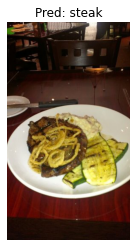

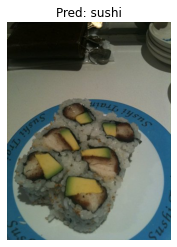

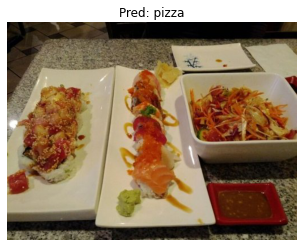

In [40]:
# Get a random subset
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot(model=model,
                image_path=image_path,
                class_names=class_names,
                image_size=(224,224))

## Making predictions on a custom image

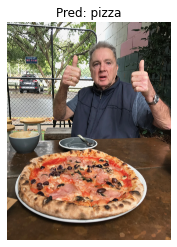

In [42]:
pred_and_plot(model, "/content/data/04-pizza-dad.jpeg", class_names=class_names, image_size=(224, 224))